# Введение

В этом задании Вы продолжите работать с данными из семинара [Articles Sharing and Reading from CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop).

In [ ]:
import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm
from scipy.sparse import coo_matrix

from IPython.display import clear_output
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

## Загрузка и предобработка данных

Загрузим данные и проведем предобраотку данных как на семинаре.

In [ ]:
!wget -q -N https://www.dropbox.com/s/z8syrl5trawxs0n/articles.zip?dl=0 -O articles.zip
!unzip -o -q articles.zip

In [ ]:
articles_df = pd.read_csv('articles/shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


In [ ]:
interactions_df = pd.read_csv('articles/users_interactions.csv')
interactions_df.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


In [ ]:
interactions_df.personId = interactions_df.personId.astype(str)
interactions_df.contentId = interactions_df.contentId.astype(str)
articles_df.contentId = articles_df.contentId.astype(str)

In [ ]:
# зададим словарь определяющий силу взаимодействия
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

interactions_df['eventStrength'] = interactions_df.eventType.apply(lambda x: event_type_strength[x])

Оставляем только тех пользователей, которые произамодействовали более чем с пятью статьями.

In [ ]:
users_interactions_count_df = (
    interactions_df
    .groupby(['personId', 'contentId'])
    .first()
    .reset_index()
    .groupby('personId').size())
print('# users:', len(users_interactions_count_df))

users_with_enough_interactions_df = \
    users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions:',len(users_with_enough_interactions_df))

# users: 1895
# users with at least 5 interactions: 1140


Оставляем только те взаимодействия, которые относятся к отфильтрованным пользователям.

In [ ]:
interactions_from_selected_users_df = interactions_df.loc[np.in1d(interactions_df.personId,
            users_with_enough_interactions_df)]

In [ ]:
print('# interactions before:', interactions_df.shape)
print('# interactions after:', interactions_from_selected_users_df.shape)

# interactions before: (72312, 9)
# interactions after: (69868, 9)


Объединяем все взаимодействия пользователя по каждой статье и сглажиываем полученный результат, взяв от него логарифм.

In [ ]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId']).eventStrength.sum()
    .apply(smooth_user_preference)
    .reset_index().set_index(['personId', 'contentId'])
)
interactions_full_df['last_timestamp'] = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId'])['timestamp'].last()
)
        
interactions_full_df = interactions_full_df.reset_index()
interactions_full_df.head(5)

,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.000000,1470395911
1,-1007001694607905623,-6623581327558800021,1.000000,1487240080
2,-1007001694607905623,-793729620925729327,1.000000,1472834892
3,-1007001694607905623,1469580151036142903,1.000000,1487240062
4,-1007001694607905623,7270966256391553686,1.584963,1485994324


Разобьём выборку на обучение и контроль по времени.

In [ ]:
from sklearn.model_selection import train_test_split

split_ts = 1475519530
interactions_train_df = interactions_full_df.loc[interactions_full_df.last_timestamp < split_ts].copy()
interactions_test_df = interactions_full_df.loc[interactions_full_df.last_timestamp >= split_ts].copy()

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

interactions_train_df.head(7)

# interactions on Train set: 29329
# interactions on Test set: 9777


,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.000000,1470395911
2,-1007001694607905623,-793729620925729327,1.000000,1472834892
6,-1032019229384696495,-1006791494035379303,1.000000,1469129122
7,-1032019229384696495,-1039912738963181810,1.000000,1459376415
8,-1032019229384696495,-1081723567492738167,2.000000,1464054093
9,-1032019229384696495,-1111518890369033396,1.000000,1470109122
10,-1032019229384696495,-1114438937697017987,3.584963,1463954865


Для удобства подсчёта качества запишем данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказаниями в виде списков.

In [ ]:
interactions = (
    interactions_train_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'contentId': 'true_train'})
    .set_index('personId')
)

interactions['true_test'] = (
    interactions_test_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
interactions.loc[pd.isnull(interactions.true_test), 'true_test'] = [
    list() for x in range(len(interactions.loc[pd.isnull(interactions.true_test), 'true_test']))]

interactions.head(5)

,true_train,true_test
personId,,
-1007001694607905623,"[-5065077552540450930, -793729620925729327]","[-6623581327558800021, 1469580151036142903, 72..."
-1032019229384696495,"[-1006791494035379303, -1039912738963181810, -...","[-1415040208471067980, -2555801390963402198, -..."
-108842214936804958,"[-1196068832249300490, -133139342397538859, -1...","[-2780168264183400543, -3060116862184714437, -..."
-1130272294246983140,"[-1150591229250318592, -1196068832249300490, -...","[-1606980109000976010, -1663441888197894674, -..."
-1160159014793528221,"[-133139342397538859, -387651900461462767, 377...",[-3462051751080362224]


## Библиотека LightFM

Для рекомендации Вы будете пользоваться библиотекой [LightFM](https://making.lyst.com/lightfm/docs/home.html), в которой реализованы популярные алгоритмы. Для оценивания качества рекомендации, как и на семинаре, будем пользоваться метрикой *precision@10*.

In [ ]:
!pip install -q lightfm
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

     |████████████████████████████████| 317kB 19.9MB/s 


## Задание 1. (2 балла)

Модели в LightFM работают с разреженными матрицами. Создайте разреженные матрицы `data_train` и `data_test` (размером количество пользователей на количество статей), такие что на пересечении строки пользователя и столбца статьи стоит сила их взаимодействия, если взаимодействие было, и стоит ноль, если взаимодействия не было.

In [ ]:
# сразу сохраняем в переменную `сorpus` тексты статей, которые используем 
сorpus = articles_df['text'].loc[articles_df['contentId'].isin(interactions_full_df.contentId.unique())]
content = articles_df['contentId'].loc[articles_df['contentId'].isin(interactions_full_df.contentId.unique())]
сorpus.shape

(2976,)

In [ ]:
users = np.unique(interactions.index)
users2idx = {user: id for id, user in enumerate(users)}
content2idx = {item: id for id, item in enumerate(content.values)}

num_users, num_items = users.shape[0], content.shape[0]
print(f'number of users: {num_users}, number of items: {num_items}')

number of users: 1112, number of items: 2976


In [ ]:
d_tr = np.zeros((num_users, num_items))
for q in tqdm(range(len(interactions_train_df))):
    user, item, strength  = interactions_train_df[['personId', 	'contentId', 'eventStrength']].iloc[q]
    if user in users2idx and item in content2idx:
       i, j = users2idx[user], content2idx[item]
       d_tr[i, j] = strength

d_ts = np.zeros((num_users, num_items))
for q in tqdm(range(len(interactions_test_df))):
    user, item, strength  = interactions_test_df[['personId', 	'contentId', 'eventStrength']].iloc[q]
    if user in users2idx and item in content2idx:
       i, j = users2idx[user], content2idx[item]
       d_ts[i, j] = strength

In [ ]:
data_train = coo_matrix(d_tr)
data_test = coo_matrix(d_ts)
data_train, data_test

(<1112x2976 sparse matrix of type '<class 'numpy.float64'>'
 	with 29302 stored elements in COOrdinate format>,
 <1112x2976 sparse matrix of type '<class 'numpy.float64'>'
 	with 9418 stored elements in COOrdinate format>)

## Задание 2. (1 балл)

Обучите модель LightFM с `loss='warp'` и посчитайте *precision@10* на тесте.

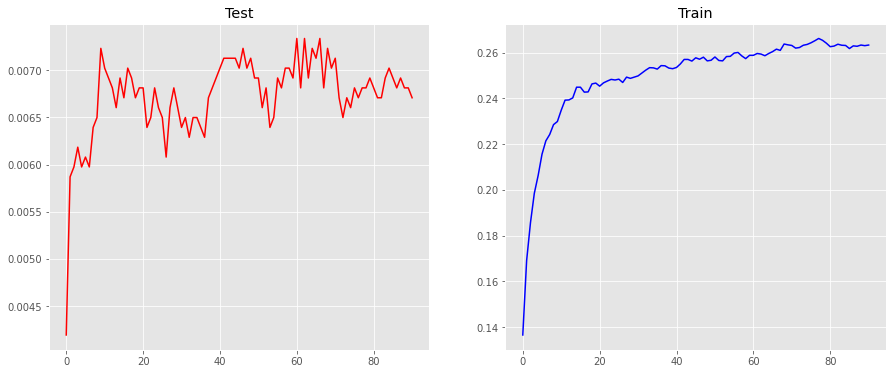

Final train score is 0.26
Final test score is 0.0066


In [ ]:
n_epochs = 100
testScore = []
trainScore = []

model = LightFM(loss='warp',
                learning_rate=0.09)

for epoch in range(n_epochs):
    model.fit_partial(data_train, epochs=1)
    trainScore.append(precision_at_k(model, test_interactions=data_train).mean())
    testScore.append(precision_at_k(model, data_test, train_interactions=data_train).mean())

    if epoch % 10 == 0 and epoch != 0:
       clear_output(wait=True)
       _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
       ax1.plot(np.arange(epoch + 1), np.array(testScore), c='r')
       ax1.set_title('Test')
       ax2.plot(np.arange(epoch + 1), np.array(trainScore), c='b')
       ax2.set_title('Train')
       plt.show()

train_score = precision_at_k(model, test_interactions=data_train, k=10).mean()
test_score = precision_at_k(model, test_interactions=data_test, train_interactions=data_train, k=10).mean()
print('Final train score is {:.2f}'.format(train_score))
print('Final test score is {:.4f}'.format(test_score))

## Задание 3. (3 балла)

При вызове метода `fit` LightFM позволяет передавать в `item_features` признаковое описание объектов. Воспользуемся этим. Будем получать признаковое описание из текста статьи в виде [TF-IDF](https://ru.wikipedia.org/wiki/TF-IDF) (можно воспользоваться `TfidfVectorizer` из scikit-learn). Создайте матрицу `feat` размером количесвто статей на размер признакового описание и обучите LightFM с `loss='warp'` и посчитайте precision@10 на тесте.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000, min_df=20, max_df=60)
embeddinds = tfidf.fit_transform(сorpus)
embeddinds.shape

(2976, 1000)

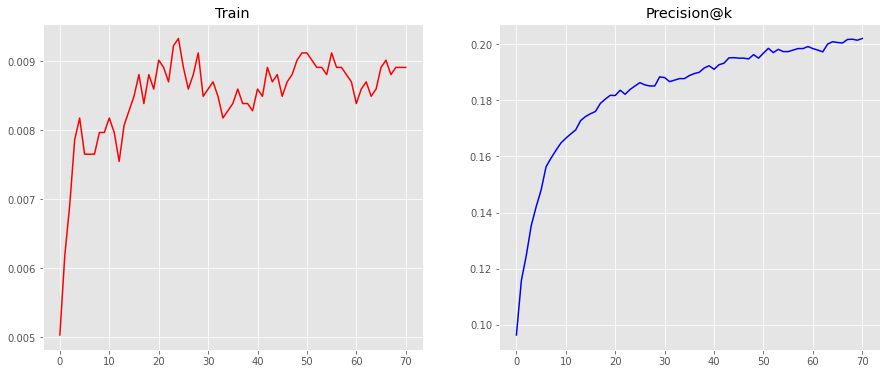

Train score is 0.20
Test score is 0.0087


In [ ]:
n_epochs = 80
testScore = []
trainScore = []

model = LightFM(loss='warp')

for epoch in range(n_epochs):
    model.fit_partial(data_train, item_features=embeddinds, epochs=1)
    trainScore.append(precision_at_k(model, item_features=embeddinds, test_interactions=data_train).mean())
    testScore.append(precision_at_k(model, data_test, item_features=embeddinds, train_interactions=data_train).mean())

    
    if epoch % 10 == 0 and epoch != 0:
       clear_output(wait=True)
       _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
       ax1.plot(np.arange(epoch + 1), np.array(testScore), c='r')
       ax1.set_title('Test')
       ax2.plot(np.arange(epoch + 1), np.array(trainScore), c='b')
       ax1.set_title('Train')
       plt.title('Precision@k')
       plt.show()

train_scroe = precision_at_k(model, test_interactions=data_train, item_features=embeddinds, k=10).mean()
test_scroe = precision_at_k(model, test_interactions=data_test, item_features=embeddinds, train_interactions=data_train, k=10).mean()
print('Train score is {:.2f}'.format(train_scroe))
print('Test score is {:.4f}'.format(test_scroe))

## Задание 4. (2 балла)

В задании 3 мы использовали сырой текст статей. В этом задании необходимо сначала сделать предобработку текста (привести к нижнему регистру, убрать стоп слова, привести слова к номральной форме и т.д.), после чего обучите модель и оценить качество на тестовых данных.

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
  

import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def preprocess(corpus):
    
    corpus = corpus.lower()
    #delete punctuation
    text_p = "".join([char for char in corpus if char not in string.punctuation])
    #tokenize
    words = word_tokenize(text_p)
    #delete stopwords
    stop_words = stopwords.words('english')
    filtered_words = [word for word in words if word not in stop_words]
    #lemmatised
    lemmatizer = WordNetLemmatizer()
    lemmatised = [lemmatizer.lemmatize(word) for word in filtered_words]
    
    return " ".join(lemmatised)

In [ ]:
tfidf = TfidfVectorizer(max_features=1000, min_df=20, max_df=60, preprocessor=preprocess)
preprossesd = tfidf.fit_transform(сorpus)
preprossesd.shape

(2976, 1000)

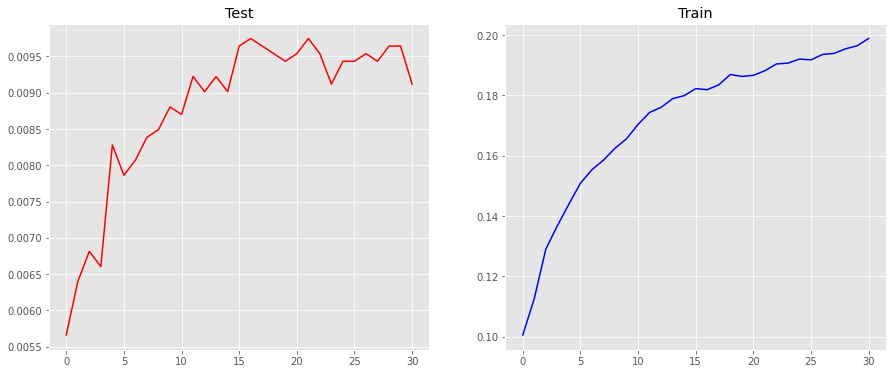

Train score is 0.20
Test score is 0.0094


In [ ]:
n_epochs = 40
testScore = []
trainScore = []

model = LightFM(loss='warp', 
                k=10)

for epoch in range(n_epochs):
    model.fit_partial(data_train, item_features=preprossesd, epochs=1)
    trainScore.append(precision_at_k(model, item_features=preprossesd, test_interactions=data_train).mean())
    testScore.append(precision_at_k(model, data_test, item_features=preprossesd, train_interactions=data_train).mean())

    
    if epoch % 10 == 0 and epoch != 0:
       clear_output(wait=True)
       _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
       ax1.plot(np.arange(epoch + 1), np.array(testScore), c='r')
       ax1.set_title('Test')
       ax2.plot(np.arange(epoch + 1), np.array(trainScore), c='b')
       ax2.set_title('Train')
       plt.show()

train_scroe = precision_at_k(model, test_interactions=data_train, item_features=preprossesd, k=10).mean()
test_scroe = precision_at_k(model, test_interactions=data_test, item_features=preprossesd, train_interactions=data_train, k=10).mean()
print('Train score is {:.2f}'.format(train_scroe))
print('Test score is {:.4f}'.format(test_scroe))

Улучшилось ли качество предсказания?

## Задание 5. (2 балла)

Подберите гиперпараметры модели LightFM (`n_components` и др.) для улучшения качества модели.

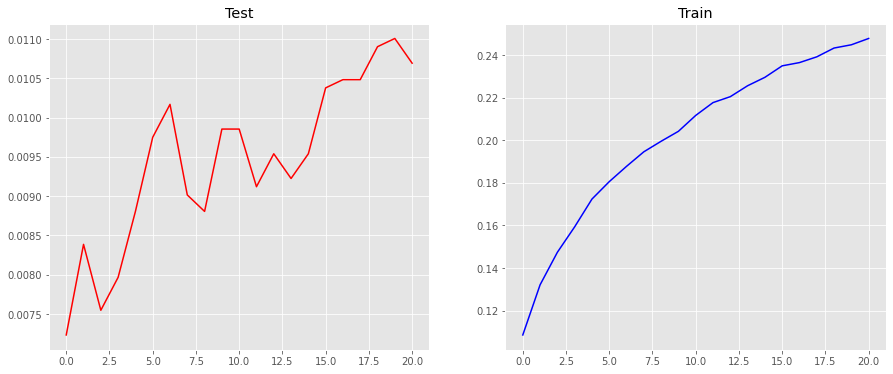

Train score is 0.26
Test score is 0.0104


In [ ]:
n_epochs = 25
testScore = []
trainScore = []

model = LightFM(loss='warp', 
                no_components=25,
                k=10)

for epoch in range(n_epochs):
    model.fit_partial(data_train, item_features=preprossesd, epochs=1)
    trainScore.append(precision_at_k(model, test_interactions=data_train, item_features=preprossesd, k=10).mean())       #train score
    testScore.append(precision_at_k(model, data_test, item_features=preprossesd, train_interactions=data_train).mean())  #test score
    
    
    if epoch % 10 == 0 and epoch != 0:
       clear_output(wait=True)
       _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
       ax1.plot(np.arange(epoch + 1), np.array(testScore), c='r')
       ax1.set_title('Test')
       ax2.plot(np.arange(epoch + 1), np.array(trainScore), c='b')
       ax2.set_title('Train')
       plt.show()

train_scroe = precision_at_k(model, test_interactions=data_train, item_features=preprossesd, k=10).mean()
test_scroe = precision_at_k(model, test_interactions=data_test, item_features=preprossesd, train_interactions=data_train, k=10).mean()
print('Train score is {:.2f}'.format(train_scroe))
print('Test score is {:.4f}'.format(test_scroe))

## Бонусное задание. (3 балла)

Выше мы использовали достаточно простое представление текста статьи в виде TF-IDF. В этом задании Вам нужно представить текст статьи (можно вместе с заголовком) в виде эмбеддинга полученного с помощью рекуррентной сети или трансформера (можно использовать любую предобученную модель, которая Вам нравится). Обучите модель с ипользованием этих эмеддингов и сравните результаты с предыдущими.